In [1]:
initial_path = 'peptide-QML/'
# initial_path = '../'

In [2]:
import numpy as np
import sys
sys.path.append(initial_path)

%load_ext autoreload
%autoreload 2
from my_code import functions as f
from my_code import pytorch_model as ptm
from my_code import quantum_nodes as qn
from my_code import pytorch_wrappers as pw

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.4) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [3]:
dim = 12
day = "0906"


# -- DATA -- #

# name of the notebook
name_notebook = "{}-{}h_h.ipynb".format(day, dim)

# load data
data_file_path = '{}data/Scores/PET/PET_SCORES.csv'.format(initial_path)
string_list, number_list = f.read_data_file(
    data_file_path,
    skip_first_line=True, 
    delimiter=', ', 
    columns_to_return=[1, 2],
    which_columns_are_numbers=[2]
    )
score_list = np.array(number_list)/100
vector_list = np.array([f.string_to_vector(string) for string in string_list]) 
X, Y, X_validation, Y_validation = f.create_validating_set(vector_list, score_list, percentage=0.1)

# Define the dataset
input_data = ptm.torch.tensor(X) 
target_data = ptm.torch.tensor(Y).view(-1, 1)

# Define the validation set
input_validation = ptm.torch.tensor(X_validation)
target_validation = ptm.torch.tensor(Y_validation).view(-1, 1)


# -- TRAINING LOOP -- #
for iii in range(5):

    for block_n_layers in range(1, 5):
        print(iii, " # ------- block_n_layers: ", block_n_layers, " ------- #")
        print("")
        print("")

        # -- QUANTUM NODE -- #

        n_aminoacids = len(string_list[0])
        n_qubits = 4

        quantum_layer = qn.circuit(
            n_qubits = n_qubits, 
            device = "default.qubit.torch",
            device_options = {'shots': None},
            embedding = qn.parts.AngleEmbedding, 
            # embedding_ansatz = qn.parts.Ansatz_11,
            block_ansatz = qn.parts.Ansatz_11,
            final_ansatz = qn.parts.Ansatz_final_11,
            measurement = qn.parts.Measurement('Z', (n_qubits-1)//2),
            # embedding_n_layers = 4,
            # different_inputs_per_layer = True,
            block_n_layers = block_n_layers,
            # wrapper_qlayer = pw.QLayerEmpty,
        )


        # -- CLASSICAL MODEL -- #
        input_dim = input_data.shape[1]

        layers = []
        layers += [ptm.nn.Linear(input_dim, 4), ptm.nn.Sigmoid()] 
        layers += [ptm.nn.Linear(4,4), quantum_layer()]
        layers += [ptm.nn.Linear(1,1)]

        # Create model and set data:
        model = ptm.pytorch_model(
            layers,    
            save_options = {'initial_path': initial_path, 'name_notebook': name_notebook},
        )
        model.set_data(
            data_X=input_data, 
            data_Y=target_data, 
            data_X_validation=input_validation,
            data_Y_validation=target_validation
        )
        model.keep_track_params=False


        # -- TRAINING -- #
        import torch.optim as optim

        # train the model
        model.train(
            optimizer= optim.Adam,
            optimizer_options={'lr': 0.02},
            num_epochs = 100,                
            batch_size = 3,
            stop_training_options = {
                'lookback_epochs': 5, 
                'threshold_slope': 0.001,
                'threshold_std_dev': 0.2
            },
        )

        # -- SAVE -- #

        # dump the object
        model.dump()

        # save string of the model
        model.save_str(
            metadata={
                "data_file_path": data_file_path,
                "n_aminoacids": n_aminoacids,
                "block_n_layers": block_n_layers,
                "n_qubits": n_qubits,
                "quantum_layer": quantum_layer.__str__(),
            }
        )

        # plot the losses of the trainig loop and save the figures
        model.plot_losses(save=True, save_txt=True)

        #save all the parameters of the model and the intermediate parameters of the model
        model.save_state_dict(intermediate=False)

        # plot the validation and save it
        model.plot_validation(save=True, fig_size=(9,9), percentatge=1)

        # print validation and save it
        model.str_validation(save=True, precision=4, percentatge=1, printing=False)

0  # ------- block_n_layers:  1  ------- #


Epoch [0/100], Loss: 21.4767, Loss validation: 21.2487


/usr/lib/python3/dist-packages/torch/autograd/__init__.py:147: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:115.)
  Variable._execution_engine.run_backward(


	 Validation string, 	 i: 0; 	 prediction: -0.3232, 	 target: -0.2505, 	 loss: 5.3493
	 Validation string, 	 i: 1; 	 prediction: -0.3357, 	 target: -0.2454, 	 loss: 8.2445
	 Validation string, 	 i: 2; 	 prediction: -0.1360, 	 target: -0.1647, 	 loss: 0.8310
Epoch [1/100], Loss: 6.7877, Loss validation: 5.9469, Time remaining: ~13.0h 46.0m 37s
	 Validation string, 	 i: 0; 	 prediction: -0.2559, 	 target: -0.2505, 	 loss: 0.0293
	 Validation string, 	 i: 1; 	 prediction: -0.3362, 	 target: -0.2454, 	 loss: 8.3291
	 Validation string, 	 i: 2; 	 prediction: -0.1045, 	 target: -0.1647, 	 loss: 3.6630
Epoch [2/100], Loss: 6.4907, Loss validation: 6.3429, Time remaining: ~13.0h 55.0m 30s
	 Validation string, 	 i: 0; 	 prediction: -0.3444, 	 target: -0.2505, 	 loss: 8.9186
	 Validation string, 	 i: 1; 	 prediction: -0.3486, 	 target: -0.2454, 	 loss: 10.7642
	 Validation string, 	 i: 2; 	 prediction: -0.1577, 	 target: -0.1647, 	 loss: 0.0491
Epoch [3/100], Loss: 6.4116, Loss validation: 6.089

KeyboardInterrupt: 

In [ ]:
# push changes to git
if initial_path != '../':
    !cd peptide-QML && git add . && git commit -m "data trained model" && git push

Saved in:  peptide-QML/checkpoints/0906/txts/0906-12h_h_model_str_2.txt
Saved in:  peptide-QML/checkpoints/0906/plots/0906-12h_h_losses_batches_2.png


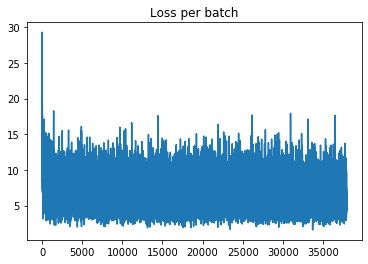

Saved in:  peptide-QML/checkpoints/0906/plots/0906-12h_h_losses_epochs_2.png


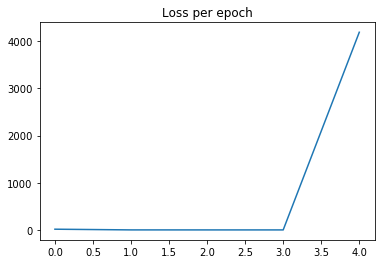

Saved in:  peptide-QML/checkpoints/0906/plots/0906-12h_h_losses_epochs_validation_2.png


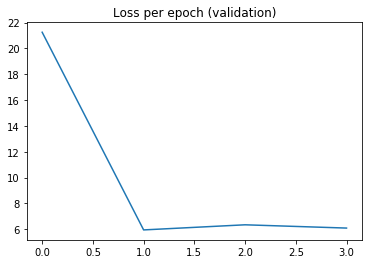

Saved in:  peptide-QML/checkpoints/0906/txts/0906-12h_h_losses_batches_2.txt
Saved in:  peptide-QML/checkpoints/0906/txts/0906-12h_h_losses_epochs_2.txt
Saved in:  peptide-QML/checkpoints/0906/txts/0906-12h_h_losses_epochs_validation_2.txt
Model saved as peptide-QML/checkpoints/0906/models/0906-12h_h_2.pth
Saved in:  peptide-QML/checkpoints/0906/plots/0906-12h_h_validation_2.png


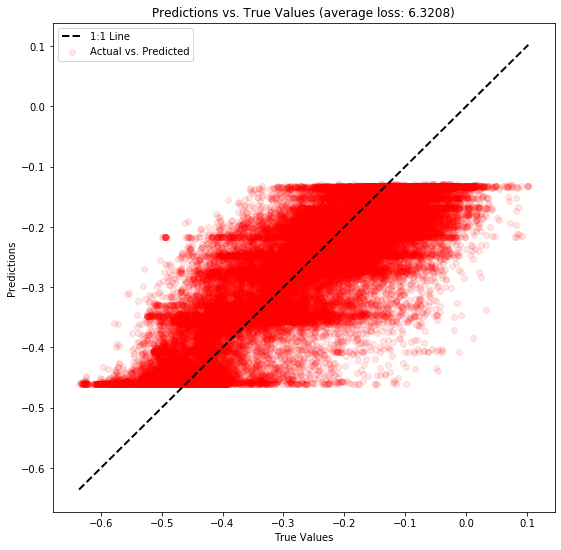

Saved in:  peptide-QML/checkpoints/0906/txts/0906-12h_h_validation_2.txt


In [4]:
# dump the object
model.dump()

# save string of the model
model.save_str(
    metadata={
        "data_file_path": data_file_path,
        "n_aminoacids": n_aminoacids,
        "block_n_layers": block_n_layers,
        "n_qubits": n_qubits,
        "quantum_layer": quantum_layer.__str__(),
    }
)

# plot the losses of the trainig loop and save the figures
model.plot_losses(save=True, save_txt=True)

#save all the parameters of the model and the intermediate parameters of the model
model.save_state_dict(intermediate=False)

# plot the validation and save it
model.plot_validation(save=True, fig_size=(9,9), percentatge=1)

# print validation and save it
model.str_validation(save=True, precision=4, percentatge=1, printing=False)